In [1]:
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import pandas as pd

import numpy as np
import random
import time
import copy

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [2]:
batch_size = 64

fpath = "/Users/aidarmamaturaimov/Downloads/PlantVillage_FYP_cl"
train_path = fpath + "/train"
val_path = fpath + "/val"

data_path = fpath
leaf_datasets = datasets.ImageFolder(
    data_path,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

In [44]:
random_seed = 33
random.seed(random_seed)
torch.manual_seed(random_seed)

dataset = {}

train_idx, valtest_idx = train_test_split(list(range(len(leaf_datasets))), test_size=0.4, random_state=random_seed)
dataset['train'] = Subset(leaf_datasets, train_idx)
valtest          = Subset(leaf_datasets, valtest_idx)


val_idx, test_idx = train_test_split(list(range(len(valtest))), test_size=0.5, random_state=random_seed)
dataset['valid'] = Subset(valtest, val_idx)
dataset['test']  = Subset(valtest, test_idx)

In [46]:
print(len(dataset['train']))
print(len(dataset['valid']))

13672
4557


In [48]:
dataloaders, batch_num = {}, {}
dataloaders['train'] = DataLoader(dataset['train'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)
dataloaders['valid'] = DataLoader(dataset['valid'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)
dataloaders['test'] = DataLoader(dataset['test'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)


batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  test/valid : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 64,  test/valid : 214 / 72 / 72


torch.Size([3, 224, 224])


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x11a0f7820>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/tf_apple_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/opt/anaconda3/envs/tf_apple_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1582, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/anaconda3/envs/tf_apple_env/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/opt/anaconda3/envs/tf_apple_env/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/anaconda3/envs/tf_apple_env/lib/python3.9/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/opt/anaconda3/envs/tf_apple_env/lib/python3.9/selectors.py", line 416, in select
    fd_event_list = se

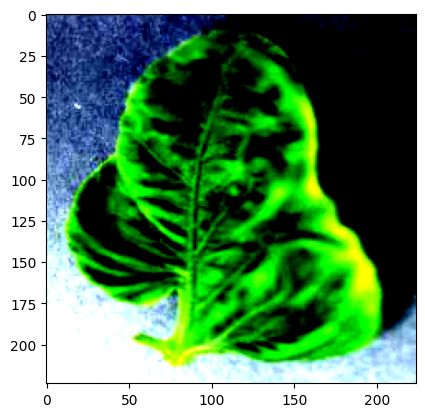

In [52]:
imgtest = None
for images, labels in dataloaders['train']:  
    imgtest = images[3]
    print(imgtest.shape)
    break

imgtest = imgtest.numpy()
imgtest = np.moveaxis(imgtest, 0, -1)
imshow(imgtest)

In [5]:

train_dir = train_path  
val_dir = val_path    


img_height = 128
img_width = 128
batch_size = 32
num_epochs = 50
num_classes = 15

class_names = [
    'Tomato___Bacterial_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___healthy',
    'Pepper,_bell___Bacterial_spot', 'Potato___Early_blight', 'Pepper,_bell___healthy',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Potato___Late_blight', 'Tomato___Target_Spot',
    'Tomato___Late_blight', 'Tomato___Septoria_leaf_spot', 'Tomato___Tomato_mosaic_virus',
    'Tomato___Early_blight', 'Tomato___Leaf_Mold', 'Potato___healthy'
]

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names
)

# Using EfficientNetB1 
base_model = tf.keras.applications.EfficientNetB1(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = True
fine_tune_at = 100  
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(num_classes, activation='softmax')(x)
model = models.Model(inputs=base_model.input, outputs=x)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])



checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
checkpoint = ModelCheckpoint('FIP_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

start_time = time.time()

Found 18230 images belonging to 15 classes.
Found 4557 images belonging to 15 classes.


2025-03-07 05:30:29.476163: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-03-07 05:30:29.476202: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-07 05:30:29.476205: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-07 05:30:29.476229: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-07 05:30:29.476242: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[checkpoint, early_stopping]  
)


# Time tracking
elapsed_time = time.time() - start_time
print(f'Training completed in: {elapsed_time // 60} minutes {elapsed_time % 60} seconds')

Epoch 1/50


/opt/anaconda3/envs/tf_apple_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-03-07 05:30:47.380325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


569/569 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.3338 - loss: 2.1067
Epoch 1: val_accuracy improved from -inf to 0.46721, saving model to FIP_model.keras
569/569 ━━━━━━━━━━━━━━━━━━━━ 344s 517ms/step - accuracy: 0.3339 - loss: 2.1062 - val_accuracy: 0.4672 - val_loss: 1.8714
Epoch 2/50
  1/569 ━━━━━━━━━━━━━━━━━━━━ 9:08 966ms/step - accuracy: 0.6562 - loss: 1.1679

/opt/anaconda3/envs/tf_apple_env/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.46721 to 0.46985, saving model to FIP_model.keras
569/569 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6562 - loss: 1.1679 - val_accuracy: 0.4699 - val_loss: 1.8534
Epoch 3/50
569/569 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.5807 - loss: 1.3315
Epoch 3: val_accuracy improved from 0.46985 to 0.58913, saving model to FIP_model.keras
569/569 ━━━━━━━━━━━━━━━━━━━━ 279s 491ms/step - accuracy: 0.5807 - loss: 1.3314 - val_accuracy: 0.5891 - val_loss: 1.3230
Epoch 4/50
  1/569 ━━━━━━━━━━━━━━━━━━━━ 12:10 1s/step - accuracy: 0.4062 - loss: 1.9014
Epoch 4: val_accuracy improved from 0.58913 to 0.59881, saving model to FIP_model.keras
569/569 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.4062 - loss: 1.9014 - val_accuracy: 0.5988 - val_loss: 1.2798
Epoch 5/50
569/569 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6440 - loss: 1.0908
Epoch 5: val_accuracy improved from 0.59881 to 0.71039, saving model to FIP_model.keras
569/569 ━━━━━━━━━━━━━━━━━

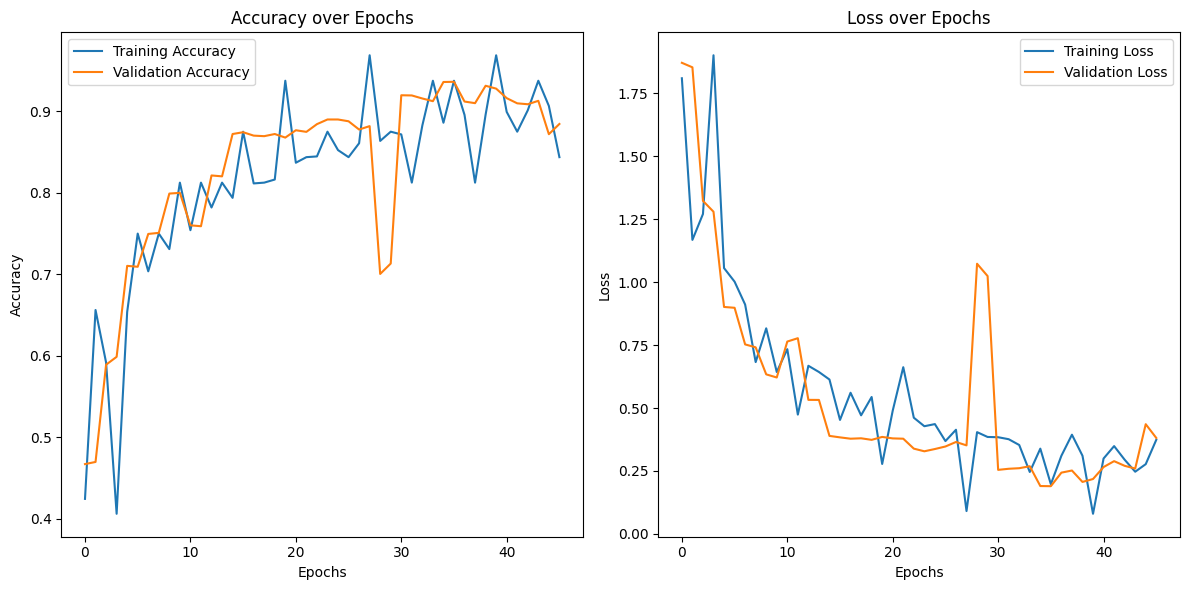

In [16]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [59]:
corrects = 0
total = 0

for data_batch, target_batch in val_generator:
    predictions = model.predict(data_batch, verbose=0)

    predicted_classes = np.argmax(predictions, axis=1)

    corrects += np.sum(predicted_classes == np.argmax(target_batch, axis=1))  # Count correct predictions
    total += len(predicted_classes)  # Total predictions made

    if total >= val_generator.samples:
        break

accuracy = corrects / total
print(f"Validation Accuracy: {accuracy * 100:.4f}%")


Validation Accuracy: 93.8556%


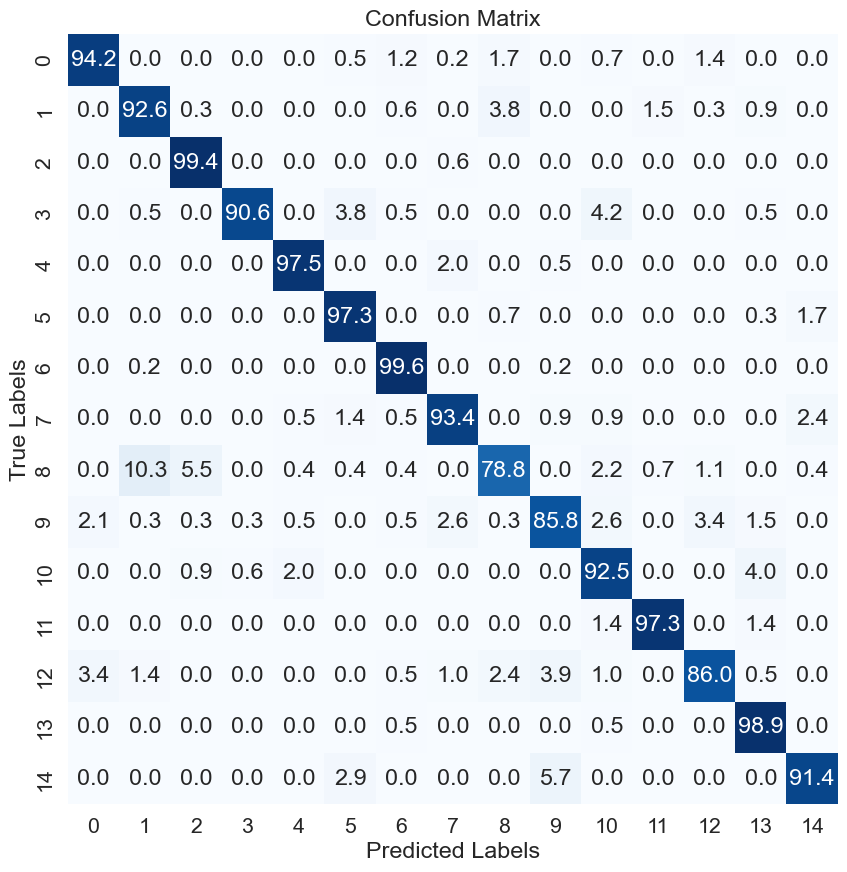

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

predicted_labels = []
true_labels = []

for data_batch, target_batch in val_generator:
    predictions = model.predict(data_batch, verbose=0)

    predicted_classes = np.argmax(predictions, axis=1)

    true_classes = np.argmax(target_batch, axis=1)

    predicted_labels.extend(predicted_classes)
    true_labels.extend(true_classes)

    if len(predicted_labels) >= val_generator.samples:
        break

predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

cm = confusion_matrix(true_labels, predicted_labels)

class_counts = np.unique(true_labels, return_counts=True)[1]
class_percents = np.round(100 * class_counts / sum(class_counts), decimals=1)

class_names = sorted(np.unique(true_labels))

plt.figure(figsize=(10, 10))
sns.set(font_scale=1.4)
sns.heatmap(np.round(100 * cm / cm.sum(axis=1)[:, np.newaxis], decimals=1), annot=True, fmt='',
            cmap="Blues", cbar=False, square=True,
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


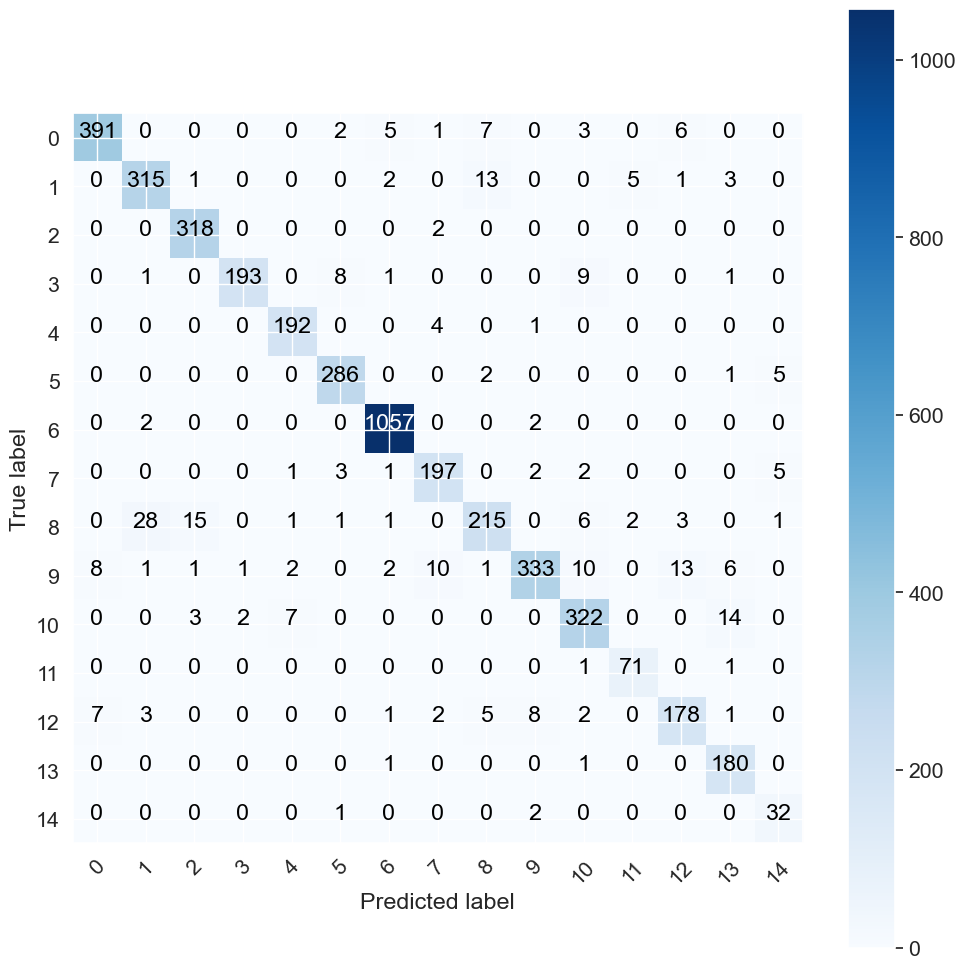

In [61]:

def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], '.0f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(true_labels, predicted_labels)
class_names = sorted(np.unique(true_labels))

plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, classes=class_names, normalize=False)  
plt.show()


In [63]:

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and f1-score
precision = np.diag(cm) / np.sum(cm, axis=0)  # Precision per class
recall = np.diag(cm) / np.sum(cm, axis=1)     # Recall per class
f1 = 2 * (precision * recall) / (precision + recall)  # F1 score per class

macro_precision = np.mean(precision)  # Average precision across all classes
macro_recall = np.mean(recall)  # Average recall across all classes
macro_f1_score = np.mean(f1)  # Average F1 score across all classes

micro_precision = np.sum(np.diag(cm)) / np.sum(cm)  # Sum of true positives / total predictions (micro precision)
micro_recall = np.sum(np.diag(cm)) / np.sum(cm, axis=1).sum()  # Sum of true positives / total actual labels (micro recall)
micro_f1_score = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)  # Micro F1 score

weighted_precision = precision_score(true_labels, predicted_labels, average='weighted')
weighted_recall = recall_score(true_labels, predicted_labels, average='weighted')
weighted_f1_score = f1_score(true_labels, predicted_labels, average='weighted')

metrics = {'Precision': [macro_precision, micro_precision, weighted_precision],
           'Recall': [macro_recall, micro_recall, weighted_recall],
           'F1-Score': [macro_f1_score, micro_f1_score, weighted_f1_score]}

df = pd.DataFrame(metrics, index=['Macro-Averaged', 'Micro-Averaged', 'Weighted'])

print(df)

                Precision    Recall  F1-Score
Macro-Averaged   0.915951  0.930178  0.921560
Micro-Averaged   0.939214  0.939214  0.939214
Weighted         0.939954  0.939214  0.938751
